In [1]:
from pathlib import Path
root = Path.cwd().parent
RESOURCES = root / 'resources'
NUMPY = root / 'numpy'
DATA = root / 'data'

In [2]:
import spacy
import pickle
from tqdm import tqdm
import string
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import keras
import os
import h5py
import warnings
from keras.models import load_model
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
embedding = spacy.load('en_core_web_lg')

In [3]:
with open(str(RESOURCES / 'questionID_question.pkl'), 'rb') as f:
    quesID_ques = pickle.load(f)

In [4]:
with open(str(RESOURCES / 'questionID_answer.pkl'), 'rb') as f:
    questionID_answer = pickle.load(f)

In [5]:
with open(str(RESOURCES / 'train2017.pkl'), 'rb') as f:
    train = pickle.load(f)

In [6]:
with open(str(DATA / 'vgg_features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(str(RESOURCES / 'le.pkl'), 'rb') as f:
    le = pickle.load(f)

In [8]:
def calc_max_question_length(quesID_ques):
    return max(len(d.split()) for k, d in quesID_ques.items())
max_length = calc_max_question_length(quesID_ques)
max_length

23

In [9]:
def clean_descriptions(description):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    desc = description.split()
    # convert to lower case
    desc = [word.lower() for word in desc]
    # remove punctuation from each token
    desc = [w.translate(table) for w in desc]
    # remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]
    # remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]
    # store as string
    res =  ' '.join(desc)
    return res

In [10]:
def create_tokenizer(quesID_ques):
    sequences = []
    for key, val in quesID_ques.items():
        res = clean_descriptions(val)
        sequences.append(res)
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(sequences)
    return tokenizer

tokenizer = create_tokenizer(quesID_ques)

In [10]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer
tokenizer = load_tokenizer(str(RESOURCES / 'tokenizer.pkl'))

In [ ]:
def create_embedding_matrix(tokenizer, embedding, save=False):
    embedding_dim = 300
    num_words = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in tqdm(tokenizer.word_index.items()):
        embedding_vector = embedding(word).vector
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector
    if save:
        with h5py.File(str(RESOURCES / 'embedding_matrix.hdf5'), 'w') as f:
            f.create_dataset('embedding_matrix', data=embedding_matrix)
    return embedding_matrix

In [11]:
def load_embedding_matrix(path):
    f = h5py.File(path, 'r')
    return f['embedding_matrix']
embedding_matrix = load_embedding_matrix(str(RESOURCES / 'embedding_matrix.hdf5'))

In [12]:
split_ratio = 0.2
val_data = {k: train[k] for k in sorted(list(train.keys())[:int(len(train) * split_ratio)])}
train_data = {k: train[k] for k in sorted(list(train.keys())[int(len(train) * split_ratio):])}

In [13]:
def data_generator(train, quesID_ques, questionID_answer, tokenizer, labelencoder, max_length, num_classes, features, batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for image_id, questions_id in train.items():
            n += 1
            image_filename = '%012d' % (image_id) + '.jpg'
            feature = features[image_filename]
            for question_id in questions_id:
                question = tokenizer.texts_to_sequences([quesID_ques[question_id]])[0]
                question = pad_sequences([question], maxlen=max_length)[0]
                answer = questionID_answer[question_id]   
                ans = labelencoder.transform([answer])
                ans = to_categorical(ans, num_classes=num_classes)[0]
                X1.append(feature)
                X2.append(question)
                y.append(ans)
            if n==batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [82]:
[x1, x2], y = next(data_generator(train, quesID_ques, questionID_answer, tokenizer, le, max_length, num_classes, features, 64))
x1.shape

(296, 4096)

In [14]:
num_words = len(tokenizer.word_index) + 1
num_classes = len(le.classes_)
embedding_dim = embedding_matrix.shape[1]

In [130]:
def define_model(lstm_units, mlp_units, vocab_size, embedding_dim, num_classes, max_length):
    image_input = keras.layers.Input(shape=(4096,))
    image_model = keras.layers.Reshape(target_shape=(4096,))(image_input)

    
    language_input = keras.layers.Input(shape=(max_length,))
    language_model = keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length, trainable=False)(language_input)
    language_model = keras.layers.LSTM(units=lstm_units, return_sequences=True)(language_model)
    language_model = keras.layers.LSTM(units=lstm_units, return_sequences=True)(language_model)
    language_model = keras.layers.LSTM(units=lstm_units, return_sequences=False)(language_model)

    combined = keras.layers.Concatenate(axis=1)([language_model, image_model])
    
    model = keras.layers.Dense(mlp_units, activation = 'tanh', kernel_initializer='uniform')(combined)
    model = keras.layers.Dropout(0.5)(model)
    model = keras.layers.Dense(mlp_units, activation = 'tanh', kernel_initializer='uniform')(model)
    model = keras.layers.Dropout(0.5)(model)
    model = keras.layers.Dense(mlp_units, activation = 'tanh', kernel_initializer='uniform')(model)
    model = keras.layers.Dropout(0.5)(model)

    output = keras.layers.Dense(num_classes, activation='softmax')(model)
    
    model = keras.models.Model(inputs=[image_input, language_input], outputs=output)
    model.summary()
    
    return model

model = define_model(512, 1024, num_words, embedding_dim, num_classes, max_length)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 23)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 23, 300)      4740600     input_24[0][0]                   
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 23, 512)      1665024     embedding_8[0][0]                
__________________________________________________________________________________________________
lstm_54 (LSTM)                  (None, 23, 512)      2099200     lstm_53[0][0]                    
___________________________________________________________________________________________

In [131]:
print("Model's layer is: ", model.layers[1])
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001))

Model's layer is:  <keras.layers.embeddings.Embedding object at 0x7f311ce763c8>


In [132]:
assert model.layers[1].trainable == False

In [18]:
model = load_model('../models/drop_02/model19.h5')
# model1 = load_model('../models/final1_nodropout/model3.h5')

In [21]:
epochs = 20
batch_size = 64
steps = len(train_data) // batch_size
val_steps = len(val_data) // batch_size
for i in range(60, 70):
    data_gen = data_generator(train, quesID_ques, questionID_answer, tokenizer, le, max_length, num_classes, features, batch_size)
    val_data_gen = data_generator(val_data, quesID_ques, questionID_answer, tokenizer, le, max_length, num_classes, features, batch_size)
    model.fit_generator(data_gen, epochs=1, steps_per_epoch=steps, validation_data=val_data_gen, validation_steps=val_steps, verbose=1)
    model.save('../models/drop_02/model{}.h5'.format(i))

Epoch 1/1
1478/1478 [==============================] - 186s 126ms/step - loss: 1.1614 - val_loss: 1.5595
Epoch 1/1
1478/1478 [==============================] - 186s 126ms/step - loss: 1.1498 - val_loss: 1.5771
Epoch 1/1
1478/1478 [==============================] - 186s 126ms/step - loss: 1.1398 - val_loss: 1.5398
Epoch 1/1
1478/1478 [==============================] - 184s 124ms/step - loss: 1.1261 - val_loss: 1.5214
Epoch 1/1
1478/1478 [==============================] - 185s 125ms/step - loss: 1.1164 - val_loss: 1.5739
Epoch 1/1
1478/1478 [==============================] - 185s 125ms/step - loss: 1.1071 - val_loss: 1.4634
Epoch 1/1
1478/1478 [==============================] - 186s 126ms/step - loss: 1.0946 - val_loss: 1.6127
Epoch 1/1
1478/1478 [==============================] - 185s 125ms/step - loss: 1.0852 - val_loss: 1.5842
Epoch 1/1
1478/1478 [==============================] - 184s 125ms/step - loss: 1.0742 - val_loss: 1.6375
Epoch 1/1
1478/1478 [==============================] - 

In [41]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from PIL import Image

ef_model = keras.applications.VGG16()
ef_model = keras.models.Model(inputs=ef_model.inputs, outputs=ef_model.layers[-2].output)
model = load_model('../models/drop_02/model69.h5')

In [50]:
import random
VAL = '../data/val/'
val_df = pickle.load(open(str(RESOURCES / 'val2017.pkl'), 'rb'))
number = list(val_df.keys())[random.choice(range(len(val_df)))]


image_id = number
image_filename = VAL + '%012d' % (image_id) + '.jpg'
questionID = val_df[image_id][random.choice(range(len(val_df[image_id])))]
question = quesID_ques[questionID]
answer = questionID_answer[questionID]

Image_filename:  ../data/val/000000473821.jpg
Question ID:  473821003
Question is:  Where is the mirror?
Original answer is:  brown
Model's answer is: 
Answer : on wall, Confident 68.43449473381042
Answer : wall, Confident 21.269619464874268
Answer : ceiling, Confident 0.7711427286267281
Answer : floor, Confident 0.7228253874927759
Answer : living room, Confident 0.4439611453562975


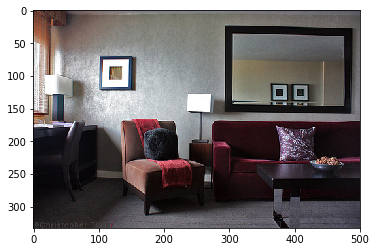

In [53]:
def extract_feature(ef_model, image_filename):
    image = load_img(image_filename, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = ef_model.predict(image)
    return feature

def text_preprocess(question, tokenizer):
    res = clean_descriptions(question)
    res = tokenizer.texts_to_sequences([res])[0]
    res = pad_sequences([res], maxlen=max_length)
    return res

def f(a,N):
    percent = []
    res = []
    for i in np.argsort(a)[::-1][:N]:
        percent.append(a[i])
        res.append(i)
    return zip(res, percent)

def show_result(image_filename, question, answer, ef_model, vqa_model, labelencoder, tokenizer, questionID):
    feature = extract_feature(ef_model, image_filename)
    question_seq = text_preprocess(question, tokenizer)
    y_pred = vqa_model.predict([feature, question_seq], verbose=0)
    top_5 = f(y_pred[0], 5)
    
    
    print("Image_filename: ", image_filename)
    print("Question ID: ", questionID)
    print("Question is: ", question)
    print("Original answer is: ", answer)
    print("Model's answer is: ")
    for res, percent in top_5:
        print("Answer : {answer}, Confident {conf}".format(answer=labelencoder.inverse_transform(res), conf=percent*100))
    image = Image.open(image_filename)
    image = np.array(image)
    plt.imshow(image)
    plt.show()

ques = 'Where is the mirror?'
show_result(image_filename, ques, answer, ef_model, model, le, tokenizer, questionID)
# show_result(image_filename, ques, answer, ef_model, model1, le, tokenizer, questionID)